In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
import os

arnaudfadja_african_plums_quality_and_defect_assessment_data_path = kagglehub.dataset_download('arnaudfadja/african-plums-quality-and-defect-assessment-data')

print('Data source import complete.')
print(f"Le dataset a été téléchargé dans le dossier : {arnaudfadja_african_plums_quality_and_defect_assessment_data_path}")

# Vous pouvez maintenant lister le contenu du dossier :
if arnaudfadja_african_plums_quality_and_defect_assessment_data_path:
    for item in os.listdir(arnaudfadja_african_plums_quality_and_defect_assessment_data_path):
        print(f"- {item}")

    # Si vous savez qu'il y a un sous-dossier 'train' par exemple :
    train_folder = os.path.join(arnaudfadja_african_plums_quality_and_defect_assessment_data_path, 'train')
    if os.path.isdir(train_folder):
        print(f"\nContenu du dossier 'train' :")
        for item in os.listdir(train_folder):
            print(f"-- {item}")


Data source import complete.
Le dataset a été téléchargé dans le dossier : /kaggle/input/african-plums-quality-and-defect-assessment-data
- african_plums_dataset


# 1) Importation des libreries et bibliothèques

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import random
import shutil
from pathlib import Path
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, Dataset, DataLoader
from torch import nn, optim
from transformers import AutoImageProcessor, ViTForImageClassification
from torch import nn, optim
import timm
from timm import create_model
from threading import Thread
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input/'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#elements = os.listdir('/kaggle/working')
#print(elements)

# 2) Chargement des données

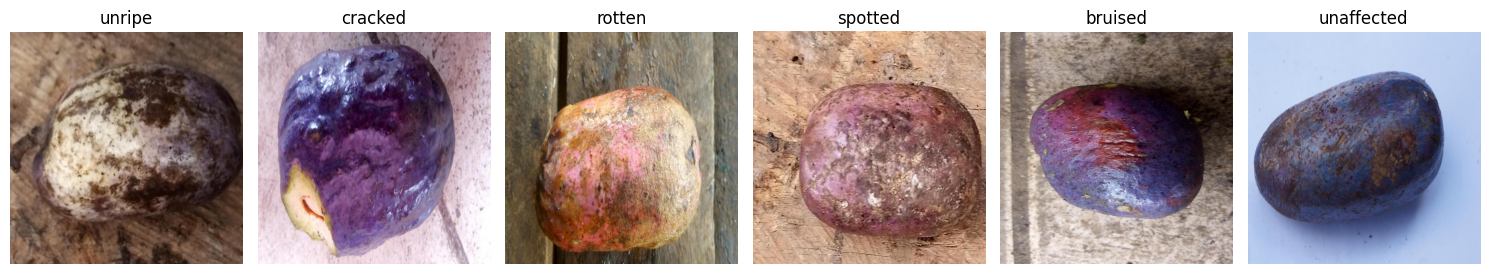

In [5]:
#repertoire racine
path = arnaudfadja_african_plums_quality_and_defect_assessment_data_path + '/african_plums_dataset'

# Chemin du dossier contenant les sous-dossiers
dossier_images = os.path.join(path, 'african_plums')

# Obtenir les sous-dossiers
classes = [os.path.join(dossier_images, nom) for nom in os.listdir(dossier_images) if os.path.isdir(os.path.join(dossier_images, nom))]

# Créer une figure avec 1 ligne et 6 colonnes
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Afficher une image de chaque dossier
for ax, dossier in zip(axes, classes[:6]):  # Limiter à 6 dossiers
    # Charger la première image du dossier
    images = os.listdir(dossier)
    if images:
        image_path = os.path.join(dossier, images[55])  # Prendre la première image
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')  # Masquer les axes
        ax.set_title(os.path.basename(dossier))  # Titre avec le nom du dossier

# Afficher la figure
plt.tight_layout()
plt.show()

In [6]:
# Chemin du dossier contenant le fichier CSV
nom_fichier = 'organized_plums_data_new.csv'

# Construire le chemin complet du fichier
chemin_fichier = os.path.join(path, nom_fichier)

# Charger le fichier CSV dans un DataFrame
df = pd.read_csv(chemin_fichier)

df.sample(10)

,Image ID,Label,Defect Type
2532,unaffected_plum_573,good,unaffected
3672,unaffected_plum_1713,good,unaffected
101,bruised_plum_102,defective,bruised
3835,unripe_plum_155,unripe,unripe
1099,rotten_plum_619,defective,rotten
929,rotten_plum_449,defective,rotten
2434,unaffected_plum_475,good,unaffected
2061,unaffected_plum_102,good,unaffected
3462,unaffected_plum_1503,good,unaffected
475,cracked_plum_157,defective,cracked


In [7]:
df.shape

(4507, 3)

In [8]:
df.columns = ['Image_Id', 'Label', 'class']
df.sample(10)

,Image_Id,Label,class
1255,spotted_plum_55,defective,spotted
2858,unaffected_plum_899,good,unaffected
3088,unaffected_plum_1129,good,unaffected
835,rotten_plum_355,defective,rotten
2357,unaffected_plum_398,good,unaffected
2787,unaffected_plum_828,good,unaffected
753,rotten_plum_273,defective,rotten
959,rotten_plum_479,defective,rotten
3098,unaffected_plum_1139,good,unaffected
136,bruised_plum_137,defective,bruised


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_Id  4507 non-null   object
 1   Label     4507 non-null   object
 2   class     4507 non-null   object
dtypes: object(3)
memory usage: 105.8+ KB


In [10]:
df.isna().sum(axis=0)

,0
Image_Id,0
Label,0
class,0


In [11]:
df.duplicated().sum()
print(f"Nombre total de valeurs dupliquées : {df.duplicated().sum()}")

Nombre total de valeurs dupliquées : 0


In [12]:
print("Nombre total d'image pour chaque type de classe :")
df.groupby('class').size()

Nombre total d'image pour chaque type de classe :


,0
class,
bruised,319
cracked,162
rotten,720
spotted,759
unaffected,1721
unripe,826


In [13]:
df.groupby('Label')['class'].agg(lambda x: list(set(x))).reset_index()

,Label,class
0,defective,"[bruised, spotted, rotten, cracked]"
1,good,[unaffected]
2,unripe,[unripe]


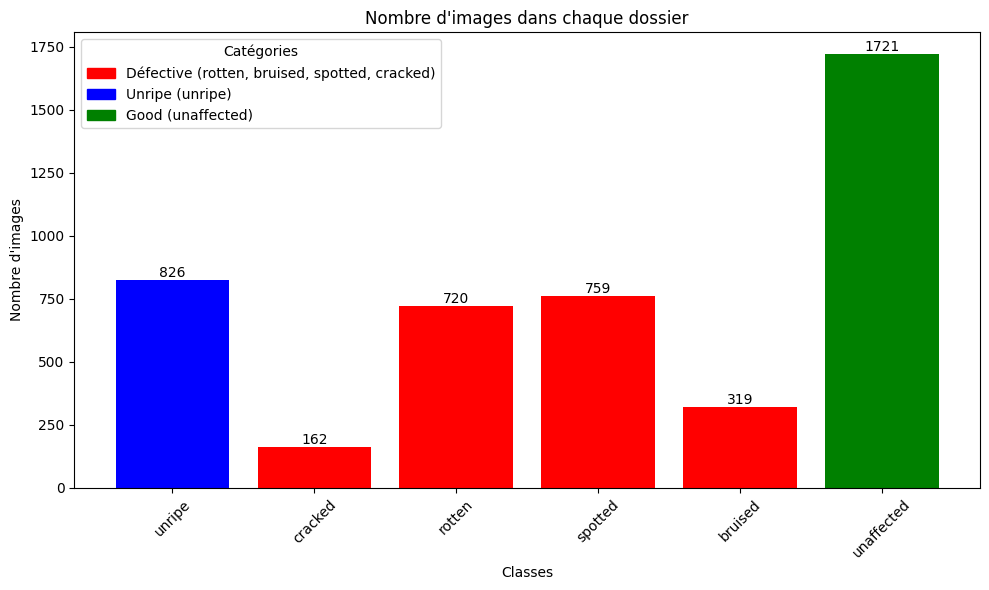

In [14]:
# Initialiser les listes pour les noms de dossiers et le nombre d'images
noms_dossiers = []
nombre_images = []

# Compter le nombre d'images dans chaque sous-dossier
for nom in os.listdir(dossier_images):
    chemin_dossier = os.path.join(dossier_images, nom)
    if os.path.isdir(chemin_dossier):
        images = [f for f in os.listdir(chemin_dossier) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        noms_dossiers.append(nom)
        nombre_images.append(len(images))

# Déterminer les couleurs des barres
couleurs = ['red' if nom in ['rotten', 'bruised', 'spotted', 'cracked'] else 'blue' if nom == 'unripe' else 'green' for nom in noms_dossiers]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
ax = plt.bar(noms_dossiers, nombre_images, color=couleurs)

# Ajouter des étiquettes sur les barres
plt.bar_label(ax)

# Configurer les axes et le titre
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images dans chaque dossier')
plt.xticks(rotation=45)
plt.tight_layout()  # Ajuster l'espacement
# Ajouter la légende
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='red', label='Défective (rotten, bruised, spotted, cracked)'),
        plt.Rectangle((0, 0), 1, 1, color='blue', label='Unripe (unripe)'),
        plt.Rectangle((0, 0), 1, 1, color='green', label='Good (unaffected)')
    ],
    title='Catégories'
)
plt.show()

En résumé, les classes **spotted, cracked, rotten et bruised** fond tous parties de la classe **defective**, et la classe **good** se confond avec la classe **unaffected**. Il est aussi à noter que les données sont très déséquilibrés mais nous allons gérer cela dans les étapes suivantes avec **la data augmentation**.

# 3) Prétraitement des images

In [15]:
# Petite fonctions pour connaître le nombre et les noms d'élements dans un dossier
def compter_elements(chemin, display_element=False):
    try:
        # Lister les éléments dans le répertoire
        elements = os.listdir(chemin)
        # Compter le nombre d'éléments
        nombre_elements = len(elements)

        if display_element:
            print(f"Éléments du répertoire : {elements}")

        print(f"Nombre d'éléments : {nombre_elements}")

    except FileNotFoundError:
        return "Le chemin spécifié n'existe pas."
    except PermissionError:
        return "Accès refusé au chemin spécifié."

In [16]:
compter_elements(path, True)

Éléments du répertoire : ['README.md', 'organized_plums_data_new.csv', 'african_plums']
Nombre d'éléments : 3


In [17]:
path

'/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset'

Le principe général pour bien organiser nos données est le suivant :

1.   Copier l'ensemble de données dans un dossier **data** (data_use) situer dans notre repertoire de travail (work_path) et y ajouter 2 dossiers **model_1 et model_2** (folder_model_1 et folder_model_2) qui contiendront les ensembles de données de chaque model.
2.   A l'intérieur de chaque dossier de model, on craira d'abord 2 dossiers **train_val_temp_1(ou 2) et test_1(ou 2)** qui contiendront respectivement **90% et 10%** des données de chaque classe contenues dans le dossier data (tout en conservant leurs classes). C-a-d 90% de spotted, 90% de enripe, ...
3.   Consernant uniquement les dossiers test_1 et train_val_temp_1, on rassemble toutes les images contenues dans les dossiers **spotted, cracked, rotte, et bruised** dans un seul dossier du nom de **defective** afin d'avoir 3 classes.
4.   Effectuer la data augmentation sur les données de test tout en équilibrant les différentes classes de sorte que les classes minoritaires aient le même nombre d'image que la classe majoritaire.
5.   Effectuer aussi la data augmentation sur les dossier train_val_temp puis les diviser en dossiers **train et val** contenant respectivement **80% et 20% des 90% des images du dossier train_val_temp**.



## 3.1) Configuration des chemins

In [18]:
# Définir les chemins
work_path = os.getcwd()
path_data = os.path.join(path, 'african_plums')  # Dossier source
data_use = os.path.join(work_path, '/data')            # Dossier cible
folder_model_1 = os.path.join(work_path, '/model_1')
folder_model_2 = os.path.join(work_path, '/model_2')
train_val_temp_1 = os.path.join(folder_model_1, 'train_val_temp_1')
train_val_temp_2 = os.path.join(folder_model_2, 'train_val_temp_2')
test_1 = os.path.join(folder_model_1, 'test_1')
test_2 = os.path.join(folder_model_2, 'test_2')

In [19]:
# Fonction pour créer un dossier (et le recréer s'il existe)
def create_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"🗑️ Dossier existant supprimé : {path}")
    os.makedirs(path)
    print(f"📁 Nouveau dossier créé : {path}")

# Création des dossiers nécessaires
print("🔧 Création des dossiers requis...")
create_folder(data_use)
create_folder(folder_model_1)
create_folder(folder_model_2)
create_folder(train_val_temp_1)
create_folder(train_val_temp_2)
create_folder(test_1)
create_folder(test_2)

# Fonction pour copier les fichiers/dossiers avec barre de progression
def copy_with_progress(src, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)

    items = os.listdir(src)
    print(f"\n📦 Copie de {len(items)} éléments de '{src}' vers '{dst}'...\n")

    for item in tqdm(items, desc="📤 Copie en cours", unit="élément"):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

# Lancer la copie
copy_with_progress(path_data, data_use)

print("\n✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉")

🔧 Création des dossiers requis...
📁 Nouveau dossier créé : /data
📁 Nouveau dossier créé : /model_1
📁 Nouveau dossier créé : /model_2
📁 Nouveau dossier créé : /model_1/train_val_temp_1
📁 Nouveau dossier créé : /model_2/train_val_temp_2
📁 Nouveau dossier créé : /model_1/test_1
📁 Nouveau dossier créé : /model_2/test_2

📦 Copie de 6 éléments de '/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums' vers '/data'...



📤 Copie en cours: 100%|██████████| 6/6 [00:22<00:00,  3.68s/élément]


✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉


In [20]:
compter_elements(work_path, True)
compter_elements(data_use, True)
compter_elements(folder_model_1, True)
compter_elements(folder_model_2, True)

Éléments du répertoire : ['.config', 'sample_data']
Nombre d'éléments : 2
Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['train_val_temp_1', 'test_1']
Nombre d'éléments : 2
Éléments du répertoire : ['train_val_temp_2', 'test_2']
Nombre d'éléments : 2


## 3.2) Séparation des images dans les dossiers model_1 et model_2




In [21]:
# Classes à traiter
classes_model_1 = ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
classes_model_2 = ['spotted', 'cracked', 'bruised', 'rotten']

def split_images(source_root, target_train, target_test, classes, ratio=0.1):
    for class_name in tqdm(classes, desc="🔍 Traitement des classes", unit="classe"):
        source_class_dir = os.path.join(source_root, class_name)
        images = os.listdir(source_class_dir)
        random.shuffle(images)

        test_count = int(len(images) * ratio)
        test_images = images[:test_count]
        train_images = images[test_count:]

        # Dossiers cibles
        class_train_dir = os.path.join(target_train, class_name)
        class_test_dir = os.path.join(target_test, class_name)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copier les images de test
        for img in test_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_test_dir, img)
            shutil.copy2(src, dst)

        # Copier les images de train_val
        for img in train_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_train_dir, img)
            shutil.copy2(src, dst)

        print(f"📂 Classe '{class_name}': {len(train_images)} entraînement/val | {len(test_images)} test")

# Séparation pour le model_1
print("\n🚀 Séparation pour le model_1")
split_images(data_use, train_val_temp_1, test_1, classes_model_1)

# Séparation pour le model_2
print("\n🚀 Séparation pour le model_2")
split_images(data_use, train_val_temp_2, test_2, classes_model_2)

print("\n✅ Séparation terminée avec succès pour les deux modèles ! 🎉")


🚀 Séparation pour le model_1


🔍 Traitement des classes:  17%|█▋        | 1/6 [00:00<00:00,  9.39classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test
📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes:  67%|██████▋   | 4/6 [00:00<00:00,  6.28classe/s]

📂 Classe 'unaffected': 1549 entraînement/val | 172 test


🔍 Traitement des classes:  83%|████████▎ | 5/6 [00:00<00:00,  5.20classe/s]

📂 Classe 'unripe': 744 entraînement/val | 82 test


🔍 Traitement des classes: 100%|██████████| 6/6 [00:01<00:00,  5.31classe/s]


📂 Classe 'rotten': 648 entraînement/val | 72 test

🚀 Séparation pour le model_2


🔍 Traitement des classes:  25%|██▌       | 1/4 [00:00<00:00,  5.34classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test


🔍 Traitement des classes:  75%|███████▌  | 3/4 [00:00<00:00, 10.75classe/s]

📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes: 100%|██████████| 4/4 [00:00<00:00,  8.15classe/s]

📂 Classe 'rotten': 648 entraînement/val | 72 test

✅ Séparation terminée avec succès pour les deux modèles ! 🎉


In [22]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


## 3.3) Création des classes 'defective'

In [23]:
# Dossiers à fusionner
defective_classes = ['spotted', 'cracked', 'bruised', 'rotten']

# Chemins vers les sous-dossiers de model_1
#train_val_temp_1 = os.path.join('model_1', 'train_val_temp_1')
#test_1 = os.path.join('model_1', 'test_1')

def merge_to_defective(root_dir):
    defective_path = os.path.join(root_dir, 'defective')
    os.makedirs(defective_path, exist_ok=True)

    # Liste dynamique des classes à fusionner à partir du contenu réel
    class_names = os.listdir(root_dir)
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)

        # On ne fusionne que les classes "défectueuses"
        if class_name in ['spotted', 'cracked', 'bruised', 'rotten'] and os.path.isdir(class_path):
            images = os.listdir(class_path)
            for img in tqdm(images, desc=f"📦 Fusion '{class_name}' → 'defective' ({root_dir})", unit="img"):
                src = os.path.join(class_path, img)
                dst = os.path.join(defective_path, img)

                # Renommage si doublon
                if os.path.exists(dst):
                    base, ext = os.path.splitext(img)
                    count = 1
                    while os.path.exists(dst):
                        dst = os.path.join(defective_path, f"{base}_{count}{ext}")
                        count += 1

                shutil.move(src, dst)

            # Supprimer le dossier une fois fusion terminé
            shutil.rmtree(class_path)
            print(f"🗑️ Supprimé : {class_path}")

        elif class_name in ['unaffected', 'unripe']:
            print(f"✅ Conservé : {class_name}")

    print(f"\n✅ Structure finale dans {root_dir} : {os.listdir(root_dir)}")

# Appliquer pour train_val_temp_1 et test_1
print("\n🚀 Fusion des classes défectueuses dans 'train_val_temp_1'")
merge_to_defective(train_val_temp_1)

print("\n🚀 Fusion des classes défectueuses dans 'test_1'")
merge_to_defective(test_1)

print("\n✅ Fusion terminée avec succès pour model_1 ! 🎉")


🚀 Fusion des classes défectueuses dans 'train_val_temp_1'


📦 Fusion 'cracked' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 146/146 [00:00<00:00, 15140.39img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 288/288 [00:00<00:00, 15979.36img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/bruised
✅ Conservé : unaffected


📦 Fusion 'rotten' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 648/648 [00:00<00:00, 19104.28img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/rotten


📦 Fusion 'spotted' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 684/684 [00:00<00:00, 25249.32img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/spotted
✅ Conservé : unripe

✅ Structure finale dans /model_1/train_val_temp_1 : ['unaffected', 'defective', 'unripe']

🚀 Fusion des classes défectueuses dans 'test_1'


📦 Fusion 'cracked' → 'defective' (/model_1/test_1): 100%|██████████| 16/16 [00:00<00:00, 24726.92img/s]


🗑️ Supprimé : /model_1/test_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/test_1): 100%|██████████| 31/31 [00:00<00:00, 27167.45img/s]


🗑️ Supprimé : /model_1/test_1/bruised
✅ Conservé : unaffected


📦 Fusion 'rotten' → 'defective' (/model_1/test_1): 100%|██████████| 72/72 [00:00<00:00, 12895.63img/s]


🗑️ Supprimé : /model_1/test_1/rotten


📦 Fusion 'spotted' → 'defective' (/model_1/test_1): 100%|██████████| 75/75 [00:00<00:00, 10358.69img/s]

🗑️ Supprimé : /model_1/test_1/spotted
✅ Conservé : unripe

✅ Structure finale dans /model_1/test_1 : ['unaffected', 'defective', 'unripe']

✅ Fusion terminée avec succès pour model_1 ! 🎉


In [24]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


In [25]:
compter_elements(train_val_temp_1, False)
compter_elements(train_val_temp_2, False)

Nombre d'éléments : 3
Nombre d'éléments : 4


## 3.4)Data augmentation, équilibrage des données et création des dossiers train, val des différents dossiers model_1 et model_2

In [26]:
def get_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
    ])

#### Augmentation et équilibrage des dossiers de test

In [27]:
# Générer un nouveau nom de fichier unique
def generate_augmented_filename(base_path, prefix="aug", ext=".jpg"):
    i = 0
    while True:
        filename = f"{prefix}_{i}{ext}"
        full_path = os.path.join(base_path, filename)
        if not os.path.exists(full_path):
            return full_path
        i += 1

# Fonction d’augmentation
def augment_class_images(class_path, target_count, transform):
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    current_count = len(images)
    to_generate = target_count - current_count

    print(f"[{os.path.basename(class_path)}] Current: {current_count}, Target: {target_count}, Generating: {to_generate}")

    for _ in tqdm(range(to_generate), desc=f"Augmenting {os.path.basename(class_path)}"):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        try:
            with Image.open(img_path).convert("RGB") as img:
                aug_img = transform(img)
                aug_img = transforms.ToPILImage()(aug_img)
                aug_path = generate_augmented_filename(class_path)
                aug_img.save(aug_path)
        except Exception as e:
           print(f"Error processing {img_path}: {e}")

# Fonction principale
def balance_dataset_with_augmentation(dataset_root):
    class_counts = {}
    class_paths = {}

    for class_name in os.listdir(dataset_root):
        class_path = os.path.join(dataset_root, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        class_counts[class_name] = len(image_files)
        class_paths[class_name] = class_path

    max_count = max(class_counts.values())
    print(f"Classe la plus fournie : {max_count} images")

    transform = get_transforms()

    for class_name, count in class_counts.items():
        if count < max_count:
            augment_class_images(class_paths[class_name], max_count, transform)
        else:
            print(f"[{class_name}] est déjà équilibrée.")

In [28]:
balance_dataset_with_augmentation(test_1)
balance_dataset_with_augmentation(test_2)

Classe la plus fournie : 194 images
[unaffected] Current: 172, Target: 194, Generating: 22


Augmenting unaffected:   0%|          | 0/22 [00:00<?, ?it/s]

Error processing /model_1/test_1/unaffected/unaffected_plum_1047.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unaffected:   9%|▉         | 2/22 [00:00<00:01, 18.67it/s]

Error processing /model_1/test_1/unaffected/unaffected_plum_1506.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unaffected:  36%|███▋      | 8/22 [00:01<00:01,  8.26it/s]

Error processing /model_1/test_1/unaffected/unaffected_plum_1385.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1157.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_908.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1222.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1157.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_805.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_452.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1525.

Augmenting unaffected:  77%|███████▋  | 17/22 [00:01<00:00, 11.16it/s]

Error processing /model_1/test_1/unaffected/unaffected_plum_504.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1497.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_179.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_452.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_475.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_1398.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_479.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unaffected/unaffected_plum_744.png

Augmenting unaffected: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]


Error processing /model_1/test_1/unaffected/unaffected_plum_1051.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
[defective] est déjà équilibrée.
[unripe] Current: 82, Target: 194, Generating: 112


Augmenting unripe:   5%|▌         | 6/112 [00:00<00:02, 52.45it/s]

Error processing /model_1/test_1/unripe/unripe_plum_675.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_738.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_278.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_600.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_236.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_553.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_268.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_157.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe:  16%|█▌        | 18/112 [00:00<00:01, 52.70it/s]

Error processing /model_1/test_1/unripe/unripe_plum_566.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_616.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_632.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_583.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_436.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_372.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_510.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe:  27%|██▋       | 30/112 [00:00<00:01, 48.82it/s]

Error processing /model_1/test_1/unripe/unripe_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_249.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_684.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_516.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_172.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_154.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_317.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_60.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
E

Augmenting unripe:  37%|███▋      | 41/112 [00:00<00:01, 51.13it/s]

Error processing /model_1/test_1/unripe/unripe_plum_738.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_675.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_817.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_321.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_510.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_57.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_11.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_516.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Er

Augmenting unripe:  47%|████▋     | 53/112 [00:01<00:01, 52.12it/s]

Error processing /model_1/test_1/unripe/unripe_plum_21.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_578.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_585.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_47.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_675.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_157.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_48.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_88.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Erro

Augmenting unripe:  53%|█████▎    | 59/112 [00:01<00:01, 51.93it/s]

Error processing /model_1/test_1/unripe/unripe_plum_566.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_317.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_358.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_688.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_660.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_435.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_557.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe:  58%|█████▊    | 65/112 [00:01<00:00, 51.18it/s]

Error processing /model_1/test_1/unripe/unripe_plum_352.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe:  63%|██████▎   | 71/112 [00:01<00:00, 51.79it/s]

Error processing /model_1/test_1/unripe/unripe_plum_21.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_742.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_616.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_566.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_390.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_435.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_352.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_709.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
E

Augmenting unripe:  74%|███████▍  | 83/112 [00:01<00:00, 51.56it/s]

Error processing /model_1/test_1/unripe/unripe_plum_616.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_798.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_319.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_813.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_372.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_134.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_374.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_275.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe:  85%|████████▍ | 95/112 [00:01<00:00, 51.08it/s]

Error processing /model_1/test_1/unripe/unripe_plum_21.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_665.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_118.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_600.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_321.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_738.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_585.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_236.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
E

Augmenting unripe:  96%|█████████▌| 107/112 [00:02<00:00, 51.64it/s]

Error processing /model_1/test_1/unripe/unripe_plum_463.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_688.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_236.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_278.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_436.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_157.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_578.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting unripe: 100%|██████████| 112/112 [00:02<00:00, 51.17it/s]


Error processing /model_1/test_1/unripe/unripe_plum_154.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_275.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_1/test_1/unripe/unripe_plum_268.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Classe la plus fournie : 75 images
[cracked] Current: 16, Target: 75, Generating: 59


Augmenting cracked:  10%|█         | 6/59 [00:00<00:00, 55.05it/s]

Error processing /model_2/test_2/cracked/cracked_plum_47.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_114.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_146.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_127.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_98.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_47.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_60.png: pic should be Tensor or ndarray. Got <class 'PIL.Imag

Augmenting cracked:  31%|███       | 18/59 [00:00<00:00, 50.86it/s]

Error processing /model_2/test_2/cracked/cracked_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_144.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_31.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_47.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_61.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_144.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_144.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_31.png: pic should be Tensor or ndarray. Got <class 'PIL.Imag

Augmenting cracked:  41%|████      | 24/59 [00:00<00:00, 49.87it/s]

Error processing /model_2/test_2/cracked/cracked_plum_61.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_23.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_156.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_146.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_84.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_133.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_156.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_60.png: pic should be Tensor or ndarray. Got <class 'PIL.Ima

Augmenting cracked:  51%|█████     | 30/59 [00:00<00:00, 50.97it/s]

Error processing /model_2/test_2/cracked/cracked_plum_127.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_13.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_98.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting cracked:  61%|██████    | 36/59 [00:00<00:00, 51.41it/s]

Error processing /model_2/test_2/cracked/cracked_plum_84.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_156.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_61.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_31.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_84.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_146.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_127.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_84.png: pic should be Tensor or ndarray. Got <class 'PIL.Imag

Augmenting cracked:  71%|███████   | 42/59 [00:00<00:00, 51.93it/s]

Error processing /model_2/test_2/cracked/cracked_plum_98.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_23.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_71.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting cracked:  81%|████████▏ | 48/59 [00:00<00:00, 52.63it/s]

Error processing /model_2/test_2/cracked/cracked_plum_71.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_146.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_114.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_133.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_127.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_156.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_127.png: pic should be Tensor or ndarray. Got <class 'PIL.I

Augmenting cracked:  92%|█████████▏| 54/59 [00:01<00:00, 51.98it/s]

Error processing /model_2/test_2/cracked/cracked_plum_61.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_61.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting cracked: 100%|██████████| 59/59 [00:01<00:00, 51.85it/s]


Error processing /model_2/test_2/cracked/cracked_plum_144.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_156.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_47.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_60.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/cracked/cracked_plum_144.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
[bruised] Current: 31, Target: 75, Generating: 44


Augmenting bruised:   0%|          | 0/44 [00:00<?, ?it/s]

Error processing /model_2/test_2/bruised/bruised_plum_227.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_297.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  14%|█▎        | 6/44 [00:00<00:00, 52.64it/s]

Error processing /model_2/test_2/bruised/bruised_plum_91.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_67.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_263.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_227.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_217.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_153.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_167.png: pic should be Tensor or ndarray. Got <class 'PIL.I

Augmenting bruised:  27%|██▋       | 12/44 [00:00<00:00, 50.85it/s]

Error processing /model_2/test_2/bruised/bruised_plum_296.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_224.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_227.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_277.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_14.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_167.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  41%|████      | 18/44 [00:00<00:00, 51.18it/s]

Error processing /model_2/test_2/bruised/bruised_plum_134.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_181.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_7.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_48.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_222.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  55%|█████▍    | 24/44 [00:00<00:00, 51.82it/s]

Error processing /model_2/test_2/bruised/bruised_plum_150.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_50.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_134.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_67.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_297.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_16.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  68%|██████▊   | 30/44 [00:00<00:00, 51.65it/s]

Error processing /model_2/test_2/bruised/bruised_plum_160.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_143.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_181.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_296.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_217.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  82%|████████▏ | 36/44 [00:00<00:00, 52.04it/s]

Error processing /model_2/test_2/bruised/bruised_plum_220.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_48.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_181.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_35.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_224.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_167.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised:  95%|█████████▌| 42/44 [00:00<00:00, 50.63it/s]

Error processing /model_2/test_2/bruised/bruised_plum_222.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_227.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_263.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/bruised/bruised_plum_16.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting bruised: 100%|██████████| 44/44 [00:00<00:00, 50.95it/s]


Error processing /model_2/test_2/bruised/bruised_plum_220.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
[rotten] Current: 72, Target: 75, Generating: 3


Augmenting rotten:   0%|          | 0/3 [00:00<?, ?it/s]

Error processing /model_2/test_2/rotten/rotten_plum_597.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
Error processing /model_2/test_2/rotten/rotten_plum_253.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.


Augmenting rotten: 100%|██████████| 3/3 [00:00<00:00, 51.00it/s]

Error processing /model_2/test_2/rotten/rotten_plum_512.png: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.
[spotted] est déjà équilibrée.


#### Augmentation et équilibrage des données de train_val_temp pour création de train et val

In [29]:
def augment_to_balance(input_dir):
    transform = get_transforms()

    # Statistiques des classes
    class_counts = {}
    class_images = {}

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            continue
        class_counts[cls] = len(images)
        class_images[cls] = images

    if not class_counts:
        print(f"⚠️ Aucune image trouvée dans {input_dir}. Traitement ignoré.")
        return

    max_count = max(class_counts.values())
    target_count = max(max_count, 1500)  # La cible est le max actuel ou 1000, le plus grand des deux
    print(f"\n📊 Classe la plus représentée initialement dans {input_dir} : {max_count} images")
    print(f"🎯 Nombre cible d'images par classe dans {input_dir} : {target_count} images")

    for cls in tqdm(class_images, desc=f"🧪 Augmentation dans {input_dir}", unit="classe"):
        cls_path = os.path.join(input_dir, cls)
        images = class_images[cls]
        current_count = len(images)
        i = 0
        while current_count < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                aug_img = transform(image)
                aug_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                aug_path = os.path.join(cls_path, aug_name)
                aug_img.save(aug_path)
                current_count += 1
                i += 1
            except Exception as e:
                print(f"⚠️ Erreur sur {img_path} : {e}")
                continue

    print(f"✅ Data augmentation terminée pour {input_dir} 🎉")

# 📁 Exécution sur les deux dossiers :
augment_to_balance(train_val_temp_1)
augment_to_balance(train_val_temp_2)


📊 Classe la plus représentée initialement dans /model_1/train_val_temp_1 : 1766 images
🎯 Nombre cible d'images par classe dans /model_1/train_val_temp_1 : 1766 images


🧪 Augmentation dans /model_1/train_val_temp_1: 100%|██████████| 3/3 [00:42<00:00, 14.23s/classe]


✅ Data augmentation terminée pour /model_1/train_val_temp_1 🎉

📊 Classe la plus représentée initialement dans /model_2/train_val_temp_2 : 684 images
🎯 Nombre cible d'images par classe dans /model_2/train_val_temp_2 : 1500 images


🧪 Augmentation dans /model_2/train_val_temp_2: 100%|██████████| 4/4 [01:52<00:00, 28.03s/classe]

✅ Data augmentation terminée pour /model_2/train_val_temp_2 🎉


In [30]:
def split_train_val(input_dir, output_dir, train_ratio=0.8):
    """
    Sépare les images de chaque classe dans un dossier en 80% train / 20% val.
    :param input_dir: train_val_temp_1 ou train_val_temp_2
    :param output_dir: model_1 ou model_2
    :param train_ratio: proportion des données pour l'entraînement
    """
    # Création des dossiers "train" et "val"
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Parcours des classes présentes dans le dossier temporaire
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Liste des images
        images = [img for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        # Split des images
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Création des dossiers de sortie pour chaque classe
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Déplacement des images vers le dossier train
        for img in tqdm(train_images, desc=f"📁 {class_name} → train", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        # Déplacement des images vers le dossier val
        for img in tqdm(val_images, desc=f"📁 {class_name} → val", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_dir, img))

    # Nettoyage du dossier temporaire une fois le split terminé
    print(f"\n🧹 Suppression du dossier temporaire : {input_dir}")
    shutil.rmtree(input_dir)
    print(f"✅ Split terminé pour {output_dir} ! 🎉")


# ✨ Application aux deux modèles
split_train_val(train_val_temp_1, folder_model_1)
split_train_val(train_val_temp_2, folder_model_2)

📁 unripe → val: 100%|██████████| 354/354 [00:00<00:00, 40326.56img/s]



🧹 Suppression du dossier temporaire : /model_1/train_val_temp_1
✅ Split terminé pour /model_1 ! 🎉


📁 spotted → val: 100%|██████████| 300/300 [00:00<00:00, 39694.98img/s]


🧹 Suppression du dossier temporaire : /model_2/train_val_temp_2
✅ Split terminé pour /model_2 ! 🎉


In [31]:
compter_elements(train_val_temp_1, False)

"Le chemin spécifié n'existe pas."

In [32]:
compter_elements(train_val_temp_2, False)

"Le chemin spécifié n'existe pas."

In [33]:
compter_elements(folder_model_1, True)
compter_elements(folder_model_1 + '/train', True)
compter_elements(folder_model_1 + '/val', True)
compter_elements(folder_model_1 + '/test_1', True)
compter_elements(folder_model_2, True)
compter_elements(folder_model_2  + '/train', True)
compter_elements(folder_model_2 + '/val', True)
compter_elements(folder_model_2 + '/test_2', True)

Éléments du répertoire : ['val', 'train', 'test_1']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['val', 'train', 'test_2']
Nombre d'éléments : 3
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


In [34]:
# Assuming 'test_1' directory exists as per your provided code.
test_1_dir = folder_model_1 + '/test_1'

def get_random_defective_image(test_dir):
    """
    Returns the path to a random defective image from the test directory.
    """
    defective_dirs = [d for d in os.listdir(test_dir) if d == 'defective' and os.path.isdir(os.path.join(test_dir,d))]
    if not defective_dirs:
        return None  # Handle the case where 'defective' directory doesn't exist

    defective_dir = os.path.join(test_dir, defective_dirs[0])
    images = [f for f in os.listdir(defective_dir) if os.path.isfile(os.path.join(defective_dir, f))]
    if not images:
        return None # Handle the case where the 'defective' directory is empty

    random_image = random.choice(images)
    return os.path.join(defective_dir, random_image)

image_test = get_random_defective_image(test_1_dir)
image_test

'/model_1/test_1/defective/rotten_plum_591.png'

Notre architecture de dossier et donc bel est conçu avec 2 dossiers **model1 et model2** contenant chacun 3 dossiers **train, val et test** contenant eux aussi des classes d'images déjà équilibrée (defective, unripe et unaffected) pour le model_1 et (spotted, cracked, rotten et bruised) pour le dossier model_2.

# 4) Conception du model

Maintenant passons à la création de notre architecture de classification d'image.
*   **Objectif** : Utiliser 2 models dont l'un laisse la place à l'autre si il prédit une image comme étant 'defective'
*   **Modele utilisé** : **ViT (Vision Tranformers)**
*   **Métriques** : Accuracy, precission, recall, f1_score, matrice de confusion
*   **Régularisation** : Early stopping, label smoothing, dropout
*   **Optimisation** : AdamW (Adaptive Moment Estimation with Weight Decay), weight decay


## 4.1) Entrainement, validation et test

In [35]:
class Config:
    """
    Configuration pour les modèles de classification hiérarchique.
    Définit les chemins des données, les noms des classes et les hyperparamètres d'entraînement.
    """
    # Paths pour model_1 (classification de niveau supérieur en 3 classes)
    MODEL1 = {
        'train': folder_model_1 + '/train',
        'val': folder_model_1 + '/val',
        'test': folder_model_1 + '/test_1',
        'classes': ['defective', 'unaffected', 'unripe'],
        'num_classes': 3
    }

    # Paths pour model_2 (classification de niveau inférieur en 4 classes, pour les cas 'defective')
    MODEL2 = {
        'train': folder_model_2 + '/train',
        'val': folder_model_2 + '/val',
        'test': folder_model_2 + '/test_2',
        'classes': ['spotted', 'cracked', 'bruised', 'rotten'],
        'num_classes': 4
    }

    # Paramètres communs
    BATCH_SIZE = 32
    NUM_EPOCHS = 15
    LR = 2e-5
    PATIENCE = 5
    IMG_SIZE = 224
    MODEL_NAME = 'vit_base_patch16_224'
    DROP_RATE = 0.1
    ATTENTION_DROP_RATE = 0.1
    DROP_PATH_RATE = 0.1
    WEIGHT_DECAY = 0.0001
    LABEL_SMOOTHING = 0.1
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)

In [36]:
def get_dataloaders(data_path, batch_size, img_size, mean, std):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    dataset = datasets.ImageFolder(data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [37]:
def build_vit_model(num_classes):
    model = timm.create_model(
        Config.MODEL_NAME,
        pretrained=True,
        num_classes=num_classes,
        drop_rate=Config.DROP_RATE,
        drop_path_rate=Config.DROP_PATH_RATE,
        attn_drop_rate=Config.ATTENTION_DROP_RATE
    )
    return model

In [38]:
def train_model(model, train_loader, val_loader, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= Config.PATIENCE:
                print("Early stopping")
                break

In [39]:
def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return total_loss / total, correct / total

In [40]:
def test_model(model, loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())

    # Rapport texte
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # Matrice de confusion
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vérité")
    plt.tight_layout()
    plt.show()

In [41]:
def main():
    # Model 1

    train_loader1 = get_dataloaders(Config.MODEL1['train'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)
    val_loader1 = get_dataloaders(Config.MODEL1['val'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)
    test_loader1 = get_dataloaders(Config.MODEL1['test'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)

    model1 = build_vit_model(Config.MODEL1['num_classes'])
    print("🚀 Entrainement du Model 1")
    train_model(model1, train_loader1, val_loader1, Config.NUM_EPOCHS, "model1_best.pt")
    model1.load_state_dict(torch.load("model1_best.pt"))
    print("🚀 Test du Model 1")
    test_model(model1, test_loader1, Config.MODEL1['classes'])

    # Model 2
    train_loader2 = get_dataloaders(Config.MODEL2['train'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)
    val_loader2 = get_dataloaders(Config.MODEL2['val'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)
    test_loader2 = get_dataloaders(Config.MODEL2['test'], Config.BATCH_SIZE, Config.IMG_SIZE, Config.MEAN, Config.STD)

    model2 = build_vit_model(Config.MODEL2['num_classes'])
    print("🚀 Entrainement du Model 2")
    train_model(model2, train_loader2, val_loader2, Config.NUM_EPOCHS, "model2_best.pt")
    model2.load_state_dict(torch.load("model2_best.pt"))
    print("🚀 Test du Model 2")
    test_model(model2, test_loader2, Config.MODEL2['classes'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

🚀 Entrainement du Model 1
Epoch 1/15, Train Loss: 0.7114, Train Acc: 0.7521, Val Loss: 0.3867, Val Acc: 0.8569
Epoch 2/15, Train Loss: 0.5396, Train Acc: 0.8699, Val Loss: 0.4117, Val Acc: 0.8427
Epoch 3/15, Train Loss: 0.4888, Train Acc: 0.8975, Val Loss: 0.4147, Val Acc: 0.8540
Epoch 4/15, Train Loss: 0.4379, Train Acc: 0.9242, Val Loss: 0.4651, Val Acc: 0.8456
Epoch 5/15, Train Loss: 0.4212, Train Acc: 0.9351, Val Loss: 0.4131, Val Acc: 0.8597
Epoch 6/15, Train Loss: 0.4029, Train Acc: 0.9455, Val Loss: 0.4708, Val Acc: 0.8427
Early stopping
🚀 Test du Model 1

Classification Report:
              precision    recall  f1-score   support

   defective       0.90      0.81      0.85       194
  unaffected       0.83      0.91      0.87       172
      unripe       0.82      0.85      0.84        82

    accuracy                           0.86       448
   macro avg       0.85      0.86      0.85       448
weighted avg       0.86      0.86      0.86       448



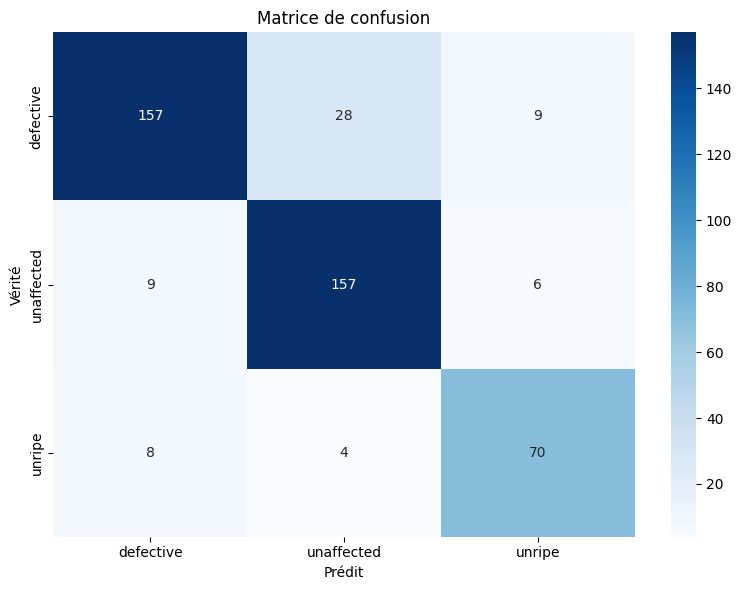

🚀 Entrainement du Model 2
Epoch 1/15, Train Loss: 1.0339, Train Acc: 0.6198, Val Loss: 0.6403, Val Acc: 0.7558
Epoch 2/15, Train Loss: 0.7777, Train Acc: 0.7792, Val Loss: 0.5048, Val Acc: 0.8092
Epoch 3/15, Train Loss: 0.6409, Train Acc: 0.8523, Val Loss: 0.5274, Val Acc: 0.7958
Epoch 4/15, Train Loss: 0.5503, Train Acc: 0.9087, Val Loss: 0.4431, Val Acc: 0.8508
Epoch 5/15, Train Loss: 0.5018, Train Acc: 0.9315, Val Loss: 0.4417, Val Acc: 0.8525
Epoch 6/15, Train Loss: 0.4667, Train Acc: 0.9498, Val Loss: 0.4448, Val Acc: 0.8575
Epoch 7/15, Train Loss: 0.4490, Train Acc: 0.9567, Val Loss: 0.4732, Val Acc: 0.8467
Epoch 8/15, Train Loss: 0.4376, Train Acc: 0.9646, Val Loss: 0.4684, Val Acc: 0.8642
Epoch 9/15, Train Loss: 0.4298, Train Acc: 0.9654, Val Loss: 0.4609, Val Acc: 0.8558
Epoch 10/15, Train Loss: 0.4135, Train Acc: 0.9712, Val Loss: 0.4596, Val Acc: 0.8575
Early stopping
🚀 Test du Model 2

Classification Report:
              precision    recall  f1-score   support

     spotte

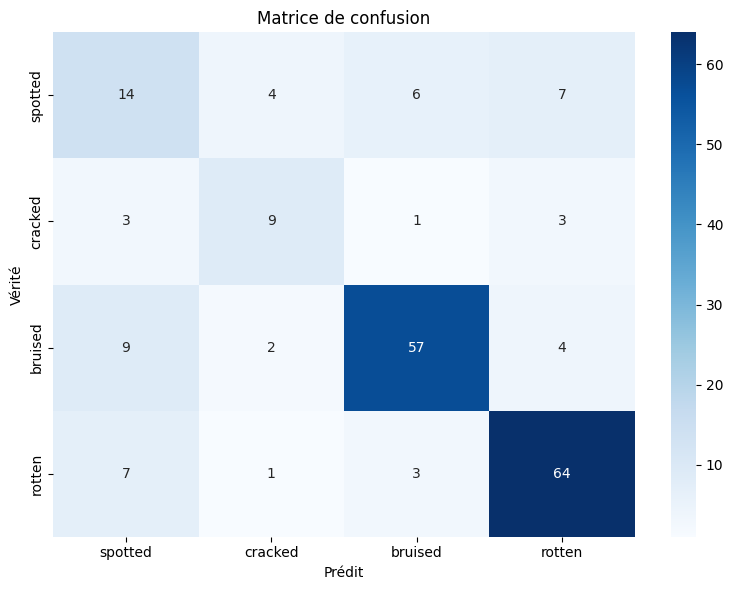

In [42]:
if __name__ == '__main__':
    main()

In [49]:
image_test = get_random_defective_image(test_1_dir)
image_test

'/model_1/test_1/defective/bruised_plum_142.png'

In [50]:
image_test

'/model_1/test_1/defective/bruised_plum_142.png'

## 4.2) Configuration et essai pour une utilisation extérieur

In [51]:
# Configuration
class Config_Pred:
    MODEL_NAME = 'vit_base_patch16_224'
    IMG_SIZE = 224
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    MODEL1_CLASSES = ['defective', 'unaffected', 'unripe']
    MODEL2_CLASSES = ['spotted', 'cracked', 'bruised', 'rotten']
    MODEL1_NUM_CLASSES = 3
    MODEL2_NUM_CLASSES = 4

In [52]:
# Fonction de chargement de modèle
def load_model(path, num_classes):
    model = create_model(
        Config_Pred.MODEL_NAME,
        pretrained=False,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(Config.MEAN, Config.STD)
])

# Fonction de prédiction hiérarchique
def predict_hierarchical(image_path):
    # Charger image
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Charger et prédire avec model1
    model1 = load_model("model1_best.pt", Config_Pred.MODEL1_NUM_CLASSES)
    with torch.no_grad():
        output1 = model1(img_tensor)
        pred1 = torch.argmax(output1, dim=1).item()
        class1 = Config_Pred.MODEL1_CLASSES[pred1]

    # Si 'defective', prédire avec model2
    if class1 == "defective":
        model2 = load_model("model2_best.pt", Config_Pred.MODEL2_NUM_CLASSES)
        with torch.no_grad():
            output2 = model2(img_tensor)
            pred2 = torch.argmax(output2, dim=1).item()
            class2 = Config_Pred.MODEL2_CLASSES[pred2]
        return {"level1": class1, "level2": class2}
    else:
        return {"level1": class1, "level2": None}

In [57]:
# Exemple d'utilisation
image_path = image_test
result = predict_hierarchical(image_path)
print("Résultat hiérarchique:", result)

Résultat hiérarchique: {'level1': 'defective', 'level2': 'spotted'}


## 4.3) Teléchargement des models en local

In [ ]:
from google.colab import files

# Si les modèles sont dans le dossier courant
files.download("model1_best.pt")
files.download("model2_best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>